In [ ]:
import os
import re
import pickle
from os import path
import pandas as pd
import numpy as np
import json
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
!pip install kneed

In [ ]:
from kneed import KneeLocator

## token counts and unique token counts:

In [ ]:
!unzip /content/light_novel.zip

In [ ]:
series_list = os.listdir(f"/content/light_novel")
series_list = [i for i in series_list if not i.startswith(".")]

In [ ]:
def proc(filename):
  # loading a file and return in json format
  
  with open(filename) as file:
    data=json.load(file)
  return data

In [ ]:
def get_token(data_path):
  # input: path for the .tokens file
  # output: (number of tokens, number of unique tokens)
  data = open(data_path)
  a = 0
  token_list = []
  for i in data:
    if a == 0:
      a = a+1
      continue
    token_list.append(i.split()[4])
    a = a+1
  return len(token_list),len(set(token_list))

In [ ]:
df = pd.DataFrame()

In [ ]:
for series in series_list:

  volume_list = os.listdir(f"light_novel/{series}")
  volume_list = [i for i in volume_list if not i.startswith('.')]

  print(f"processing {series}")

  for volume in volume_list:

    print(f"processing {series} {volume}")
    idd=f"/content/light_novel/{series}/{volume}/{series}_{volume}_output/{series}_{volume}"
    data_character=proc(f"{idd}.book")
    data_token=f"{idd}.tokens"

    num_token,num_unique = get_token(data_token)
    new = {"series":series,"volume":volume,"num_token":num_token,"unique_token":num_unique}
    df = df.append(new,ignore_index=True)


In [ ]:
def get_token(data_path):
  # input: path for the .tokens file
  # output: (number of tokens, number of unique tokens)
  data = open(data_path)
  a = 0
  token_list = []
  for i in data:
    if a == 0:
      a = a+1
      continue
    token_list.append(i.split()[4])
    a = a+1
  return set(token_list)

In [ ]:
# get a set of unique tokens
unique = set()
for series in series_list:

  volume_list = os.listdir(f"light_novel/{series}")
  volume_list = [i for i in volume_list if not i.startswith('.')]

  print(f"processing {series}")

  for volume in volume_list:

    print(f"processing {series} {volume}")
    idd=f"/content/light_novel/{series}/{volume}/{series}_{volume}_output/{series}_{volume}"
    data_character=proc(f"{idd}.book")
    data_token=f"{idd}.tokens"

    unique.update(get_token(data_token))
    

In [ ]:
len(unique)

98698

In [ ]:
df.to_csv('/content/token_count.csv')

In [ ]:
token_count = pd.read_csv('/content/token_count.csv')

In [ ]:
sum(token_count.num_token)/290,sum(token_count.unique_token)/290

(58538.94482758621, 5003.4)

## character mention counts:

In [ ]:
!unzip /content/light_novel.zip

In [ ]:
def mention_counts(data_path):
  # input: path for the .book file
  # output: dictionary with rank and count
  data=proc(data_path)
  character_count = {}
  for i in data["characters"]:
      character_id=i["id"]
      mention = i["mentions"]["proper"]
      count=i["count"]
      if len(mention) > 0:
        character_count[character_id] = count
      
      count = sorted(list(character_count.values()),reverse = True)
      count_normalized = [i/sum(count) for i in count]
  return {i+1:c for i,c in enumerate(count_normalized)}


In [ ]:
def plot_counts(count_dict):
  # input: dictionary with rank and count
  # take the top 20
  xticks = [1,3,5,9,15,30]
  xidx = [i-1 for i in xticks]
  plt.plot(list(count_dict.keys())[:70],list(count_dict.values())[:70])
  plt.plot([list(count_dict.keys())[i] for i in xidx],[list(count_dict.values())[i] for i in xidx],"o")
  plt.xlabel("frequency rank")
  plt.ylabel("frequency_normalized")
  plt.title("frequency of characters mentions vs frequency rank")
  plt.xticks(xticks)

In [ ]:
mc_total = {}
mc_len = []

for series in series_list:

  volume_list = os.listdir(f"light_novel/{series}")
  volume_list = [i for i in volume_list if not i.startswith('.')]

  print(f"processing {series}")

  for volume in volume_list:

    idd=f"/content/light_novel/{series}/{volume}/{series}_{volume}_output/{series}_{volume}"
    m_c=mention_counts(f"{idd}.book")
    mc_len.append(len(m_c))

    for i,c in m_c.items():
      mc_total[i] = mc_total.get(i,0)+c

In [ ]:
np.max(mc_len)

193

In [ ]:
pickle.dump(mc_total, open('mention_count.pickle', 'wb'))
with open('/content/mention_count.pickle', 'rb') as f:
    mc_total = pickle.load(f)

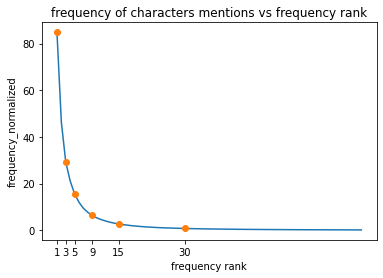

In [ ]:
plot_counts(mc_total)

### locate the cut-off point with maximum curvature

In [ ]:
x = list(mc_total.keys())[:70]
y = list(mc_total.values())[:70]

In [ ]:
#first derivatives 
dx= np.gradient(x)
dy = np.gradient(y)

#second derivatives 
d2x = np.gradient(dx)
d2y = np.gradient(dy)

#calculation of curvature from the typical formula
curvature = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5

In [ ]:
curvature.argmax()

9

In [ ]:
kn = KneeLocator(
    x,
    y,
    S=1,
    curve='convex',
    direction='decreasing',
    interp_method='interp1d'
)

print(kn.knee)

9


## distribution of genres

In [ ]:
def get_num_volumes(series):
  # get the number of volumes inside a given series
  
  volume_list = os.listdir(f"/content/light_novel/{series}")
  volume_list = [i for i in volume_list if i.startswith('Volume')]
  return len(volume_list)

In [ ]:
my_dict = pickle.load(open('/content/all_dict.pickle', 'rb'))
series_dict = {}
for novel in series_list:
  series_dict[novel] = my_dict[novel]["genre"]

In [ ]:
data_items = series_dict.items()
data_list = list(data_items)

series_df = pd.DataFrame(data_list)
series_df.columns = ["novel","genre"]

In [ ]:
series_df = series_df.join(pd.get_dummies(series_df.genre.explode()).sum(level=0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """Entry point for launching an IPython kernel.


In [ ]:
x = np.zeros(len(series_df))
series_df["num_volume"] = x

In [ ]:
for i in range(len(series_df)):

  the_series = series_df.iloc[i,0]
  series_df.loc[i,"num_volume"] = get_num_volumes(the_series)


In [ ]:
category_df = {}
for cat in series_df.columns.values[2:-1]:
  a = series_df[cat]*series_df["num_volume"]
  category_df[cat] = a.sum()

In [ ]:
data_items = category_df.items()
data_list = list(data_items)

category_df = pd.DataFrame(data_list)
category_df.columns = ["genre","number"]

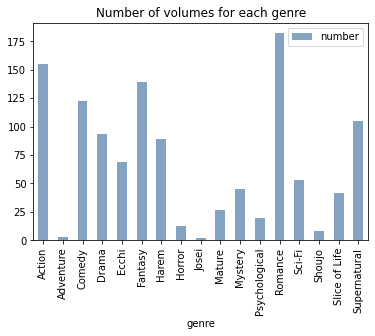

In [ ]:
import matplotlib.pyplot as plot
category_df.plot.bar(x="genre", y="number", title="Number of volumes for each genre",color=(0.2, 0.4, 0.6, 0.6));

# analysis

## make the dataframe look nicer

In [ ]:
power_df = pd.read_csv("/content/output_9.csv")

In [ ]:
def tolist(x):
  return eval(x)

In [ ]:
power_df = pd.melt(power_df, id_vars=['name','gender','series_name','volume_name','genre','poss','mod'], 
        value_vars=['power1', 'power2', 'power3','power4','power5'],
        var_name = "stage", value_name = "power")
power_df["genre"] = power_df["genre"].apply(tolist)

In [ ]:
power_df = power_df[power_df["power"] != "/"] 
# remove rows where the power is "/", meaning the character is not associated with any verb in that stage (most probably does not appear)
power_df["power"] = pd.to_numeric(power_df["power"])
power_df = power_df.join(pd.get_dummies(power_df.genre.explode()).sum(level=0))

## visualizations

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
genre_list = list(set(power_df.genre.explode()))

In [ ]:
def get_genre(df,genre=None):
  # return a dataframe for male and female separately for volumes in a given genre
  if genre!=None:
    df = df[df[genre] ==1 ]

  female = df[df["gender"] == "she/her"]
  male = df[df["gender"] == "he/him/his"]

  return female,male

#### mean and median

In [ ]:
def create_plot_mean(df,genre=None):
  # visualizations comparing the mean power of female and male characters
  
  if genre!=None:
    df = df[df[genre] ==1 ]

  female = df[df["gender"] == "she/her"]
  male = df[df["gender"] == "he/him/his"] 

  mean_female = female.groupby(['stage']).agg({'power': ['mean']})
  mean_female = mean_female.T

  mean_female["gender"] = "female"

  mean_male = male.groupby(['stage']).agg({'power': ['mean']})
  mean_male = mean_male.T

  mean_male["gender"] = "male"

  mean = pd.concat([mean_female,mean_male])
  mean = pd.melt(mean, id_vars=['gender'], 
          value_vars=['power1', 'power2', 'power3','power4','power5'],
          var_name = "stage", value_name = "power")
  
  sns.catplot("stage", "power", data = female)
  plt.yticks([-1, 0, 1])
  sns.catplot(x="stage", y="power", hue="gender",
              palette={"male": "g", "female": "m"},
              markers=["^", "o"], linestyles=["-", "--"],
              kind="point", data=mean)

In [ ]:
def create_plot_median(df,genre=None):
  # visualizations comparing the median power of female and male characters

  if genre!=None:
    df = df[df[genre] ==1 ]

  female = df[df["gender"] == "she/her"]
  male = df[df["gender"] == "he/him/his"] 

  median_female = female.groupby(['stage']).agg({'power': ['median']})
  median_female = median_female.T

  median_female["gender"] = "female"

  median_male = male.groupby(['stage']).agg({'power': ['median']})
  median_male = median_male.T

  median_male["gender"] = "male"

  median = pd.concat([median_female,median_male])
  median = pd.melt(median, id_vars=['gender'], 
          value_vars=['power1', 'power2', 'power3','power4','power5'],
          var_name = "stage", value_name = "power")
  
  sns.catplot("stage", "power", data = female)
  plt.yticks([-1, 0, 1])
  sns.catplot(x="stage", y="power", hue="gender",
              palette={"male": "g", "female": "m"},
              markers=["^", "o"], linestyles=["-", "--"],
              kind="point", data=median)

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Text(0.5, 1.0, 'male median')

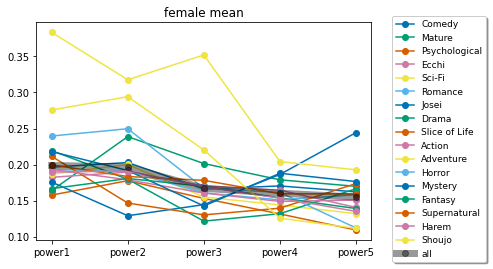

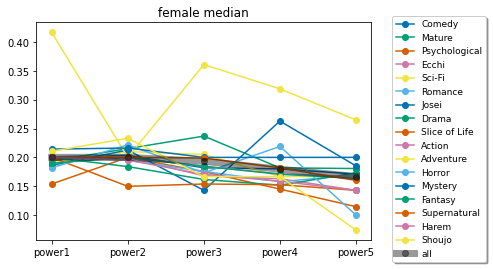

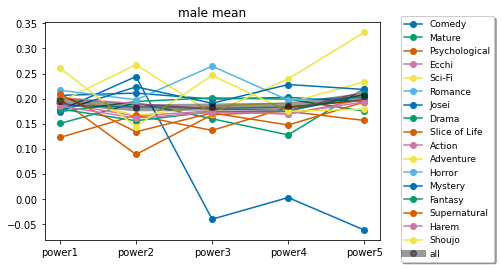

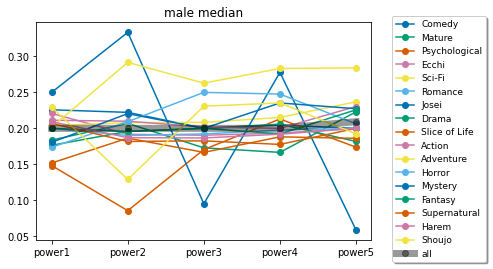

In [ ]:
# plot the mean and median power for male and female characters respectively, and group by genre

plt.style.use('seaborn-colorblind')
for genre in genre_list:
  # plot by genre
  female,male = get_genre(power_df,genre)

  female = female.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
  female.columns = list(map(''.join, female.columns.values))
  male = male.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
  male.columns = list(map(''.join, male.columns.values))
  plt.figure(1)
  plt.plot(female["stage"],female["powermean"],"-o",label=genre)
  plt.figure(2)
  plt.plot(female["stage"],female["powermedian"],"-o",label=genre)
  plt.figure(3)
  plt.plot(male["stage"],male["powermean"],"-o",label=genre)
  plt.figure(4)
  plt.plot(male["stage"],male["powermedian"],"-o",label=genre)

# plot across all genre
female = power_df[power_df.gender == "she/her"]
male = power_df[power_df.gender == "he/him/his"]
female = female.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
female.columns = list(map(''.join, female.columns.values))
male = male.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
male.columns = list(map(''.join, male.columns.values))
plt.figure(1)
plt.plot(female["stage"],female["powermean"],"k-o",label="all",linewidth=7.0,alpha=0.4)
plt.figure(2)
plt.plot(female["stage"],female["powermedian"],"k-o",label="all",linewidth=7.0,alpha=0.4)
plt.figure(3)
plt.plot(male["stage"],male["powermean"],"k-o",label="all",linewidth=7.0,alpha=0.4)
plt.figure(4)
plt.plot(male["stage"],male["powermedian"],"k-o",label="all",linewidth=7.0,alpha=0.4)


plt.figure(1)
plt.legend( prop={'size': 9}, bbox_to_anchor=(1.05, 1.05),
          ncol=1, fancybox=True, shadow=True)
plt.title("female mean")
plt.figure(2)
plt.legend( prop={'size': 9}, bbox_to_anchor=(1.05, 1.05),
          ncol=1, fancybox=True, shadow=True)
plt.title("female median")
plt.figure(3)
plt.legend( prop={'size': 9}, bbox_to_anchor=(1.05, 1.05),
          ncol=1, fancybox=True, shadow=True)
plt.title("male mean")
plt.figure(4)
plt.legend( prop={'size': 9}, bbox_to_anchor=(1.05, 1.05),
          ncol=1, fancybox=True, shadow=True)
plt.title("male median")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


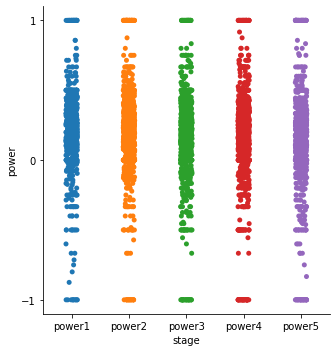

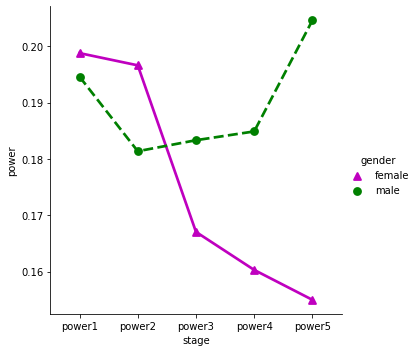

In [ ]:
create_plot_mean(power_df)

In [ ]:
def compare(df,genre):
  # comparing the mean and mean within a gender to see if they follow similar trends

  female_df,male_df = get_genre(power_df,genre)

  female = female_df.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
  female.columns = list(map(''.join, female.columns.values))
  male = male_df.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
  male.columns = list(map(''.join, male.columns.values))

  plt.figure(1)
  plt.plot(female["stage"],female["powermean"],"-o",label="mean")
  plt.plot(female["stage"],female["powermedian"],"-o",label="median")
  plt.title(f"female power in {genre}")
  plt.legend()

  plt.figure(2)
  plt.plot(male["stage"],male["powermean"],"-o",label="mean")
  plt.plot(male["stage"],male["powermedian"],"-o",label="median")
  plt.title(f"male power in {genre}")
  plt.legend()

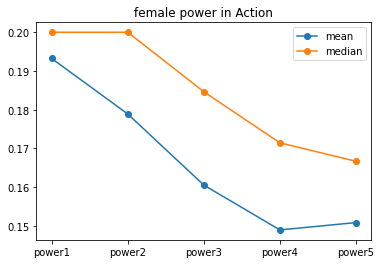

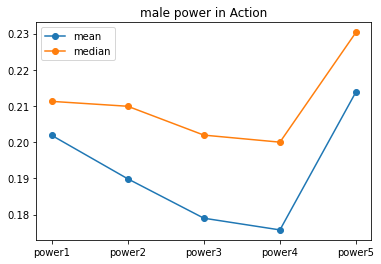

In [ ]:
compare(power_df,"Action")

In [ ]:
def compare_1(df,genre=None):
  # plot mean and median for both female and male characters on the same graph for better comparison
  female,male = get_genre(power_df,genre)

  female = female.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
  female.columns = list(map(''.join, female.columns.values))
  male = male.groupby(['stage'],as_index=False).agg({'power': ['mean','median']})
  male.columns = list(map(''.join, male.columns.values))

  plt.title(f"comparison of power in {genre}")
  plt.plot(female["stage"],female["powermean"],"b--",label="mean_female")
  plt.plot(female["stage"],female["powermedian"],"b-o",label="median_female")
  plt.plot(male["stage"],male["powermean"],"r--",label="mean_male")
  plt.plot(male["stage"],male["powermedian"],"r-o",label="median_male")
  if genre==None:
    plt.title("comparison of power across all genres")
  plt.legend()


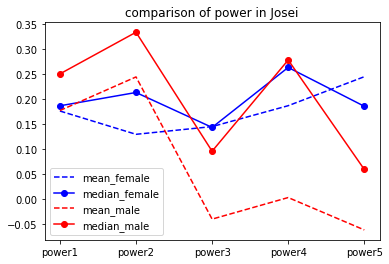

In [ ]:
compare_1(power_df,"Josei")

### significance tests - see whether the mean 

In [ ]:
def get_mean(df,genre=None,series=None,volume=None):
  # return a dictionary with keys being the stage and values being whether the mean of female is larger than mean of male
  # False: male power higher; True: female power higher

  if genre != None:
    df = df[df[genre]==1]
  if series != None:
    df = df[df["series_name"]==series]
  if volume != None:
    df = df[df["volume_name"]==volume]

  female = df[df["gender"] == "she/her"]
  male = df[df["gender"] == "he/him/his"] 

  mean_female = female.groupby(['stage']).agg({'power': ['mean']}).apply(list).to_dict()
  mean_female = mean_female[('power', 'mean')]

  mean_male = male.groupby(['stage']).agg({'power': ['mean']}).apply(list).to_dict()
  mean_male = mean_male[('power', 'mean')]

  return {p:v>mean_male[p] for p,v in mean_female.items()}

In [ ]:
get_mean(power_df,"Josei")

{'power1': False,
 'power2': False,
 'power3': True,
 'power4': True,
 'power5': True}

In [ ]:
def get_pstage(dd,stage):
  # getting the results associated with a specific stage
  # dd: compare_result 
  # a dictionary storing the result of whether female has more power than male indexed by stage, volume, and series

  return [value for key,value in dd.items() if key[2]==stage]

In [ ]:
def check(df,genre=None,series=None,volume=None):
  # check whether the power imbalanced in the mean power is significant by testing against the null hypothesis of p=0.5
  # return the proportion estimate and p-value for each stage

  if genre != None:
    df = df[df[genre]==1]
  if series != None:
    df = df[df["series_name"]==series]
  if volume != None:
    df = df[df["volume_name"]==volume]
  
  mean = get_mean(df,genre,series,volume)

  female = df[df["gender"] == "she/her"]
  male = df[df["gender"] == "he/him/his"]
  f = female.groupby(['series_name','volume_name','stage']).agg({'power': ['mean']}).apply(list).to_dict()[('power', 'mean')]
  m = male.groupby(['series_name','volume_name','stage']).agg({'power': ['mean']}).apply(list).to_dict()[('power', 'mean')]

  compare_result = {}
  for p,v in f.items():
    m_score = m.get(p,100)
    if m_score == 100:
      continue
    compare_result[p] = v>m_score
  
  result_dict = {}
  for i in ["power1","power2","power3","power4","power5"]:
    result = get_pstage(compare_result,i)
    same = sum([k==mean[i] for k in result])
    result_dict[i] = stats.binomtest(same, n=len(result), p=0.5, alternative="greater")
    if len(result)<10:
      result_dict[i] = str(stats.binomtest(same, n=len(result), p=0.5, alternative="greater"))+"*"

  return result_dict


In [ ]:
check(power_df,"Shoujo")

{'power1': "BinomTestResult(k=5, n=8, alternative='greater', proportion_estimate=0.625, pvalue=0.36328125)*",
 'power2': "BinomTestResult(k=7, n=8, alternative='greater', proportion_estimate=0.875, pvalue=0.03515625)*",
 'power3': "BinomTestResult(k=6, n=8, alternative='greater', proportion_estimate=0.75, pvalue=0.14453125)*",
 'power4': "BinomTestResult(k=7, n=8, alternative='greater', proportion_estimate=0.875, pvalue=0.03515625)*",
 'power5': "BinomTestResult(k=5, n=8, alternative='greater', proportion_estimate=0.625, pvalue=0.36328125)*"}